In [15]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd

In [16]:
# load sparse matrix:
X = io.mmread("counts.mtx")

# create anndata object
adata = anndata.AnnData(
    X=X.transpose().tocsr()
)

# load cell metadata:
cell_meta = pd.read_csv("metadata.csv")

# load gene names:
with open("gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines()

# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

# load dimensional reduction:
pca = pd.read_csv("pca.csv")
pca.index = adata.obs.index

# set pca and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

# plot a UMAP colored by sampleID to test:
sc.pl.umap(adata, color=['seurat_clusters'], frameon=False, save=True)

# save dataset as anndata format
adata.write('WT_Veh.h5ad')

# reload dataset
adata = sc.read_h5ad('WT_Veh.h5ad')


FileNotFoundError: [Errno 2] No such file or directory: 'counts.mtx'

In [5]:
import palantir
import scanpy as sc
import pandas as pd
import numpy as np
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

In [6]:
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Reset random seed
np.random.seed(5)

In [7]:
## (1) 导入数据

ad = sc.read('WT_Veh.h5ad')
ad

AnnData object with n_obs × n_vars = 500 × 32170
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'barcode', 'UMAP_1', 'UMAP_2'
    obsm: 'X_pca', 'X_umap'

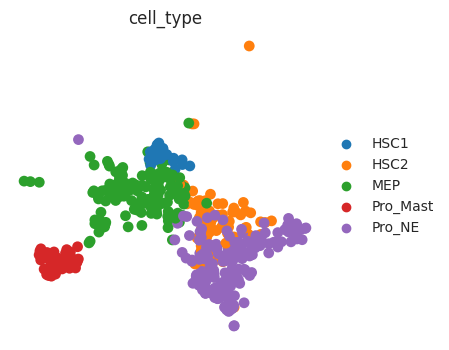

In [8]:
# plot a UMAP colored by sampleID to test:
sc.pl.umap(ad, color=['cell_type'], frameon=False, save=True)

In [9]:
pca_projections = pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names)
umap = pd.DataFrame(ad.obsm['X_umap'], index=ad.obs_names)

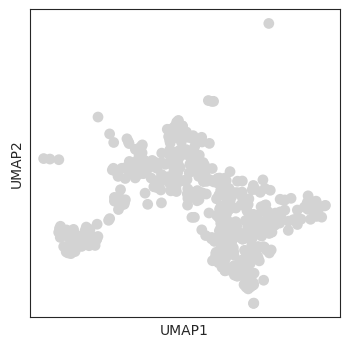

In [10]:
# umap可视化
sc.pl.embedding(ad, basis='umap')

In [9]:
## (1)Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(ad, n_components=5)

/disk2/cai031/miniconda3/envs/palantir/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ms_data = palantir.utils.determine_multiscale_space(ad)

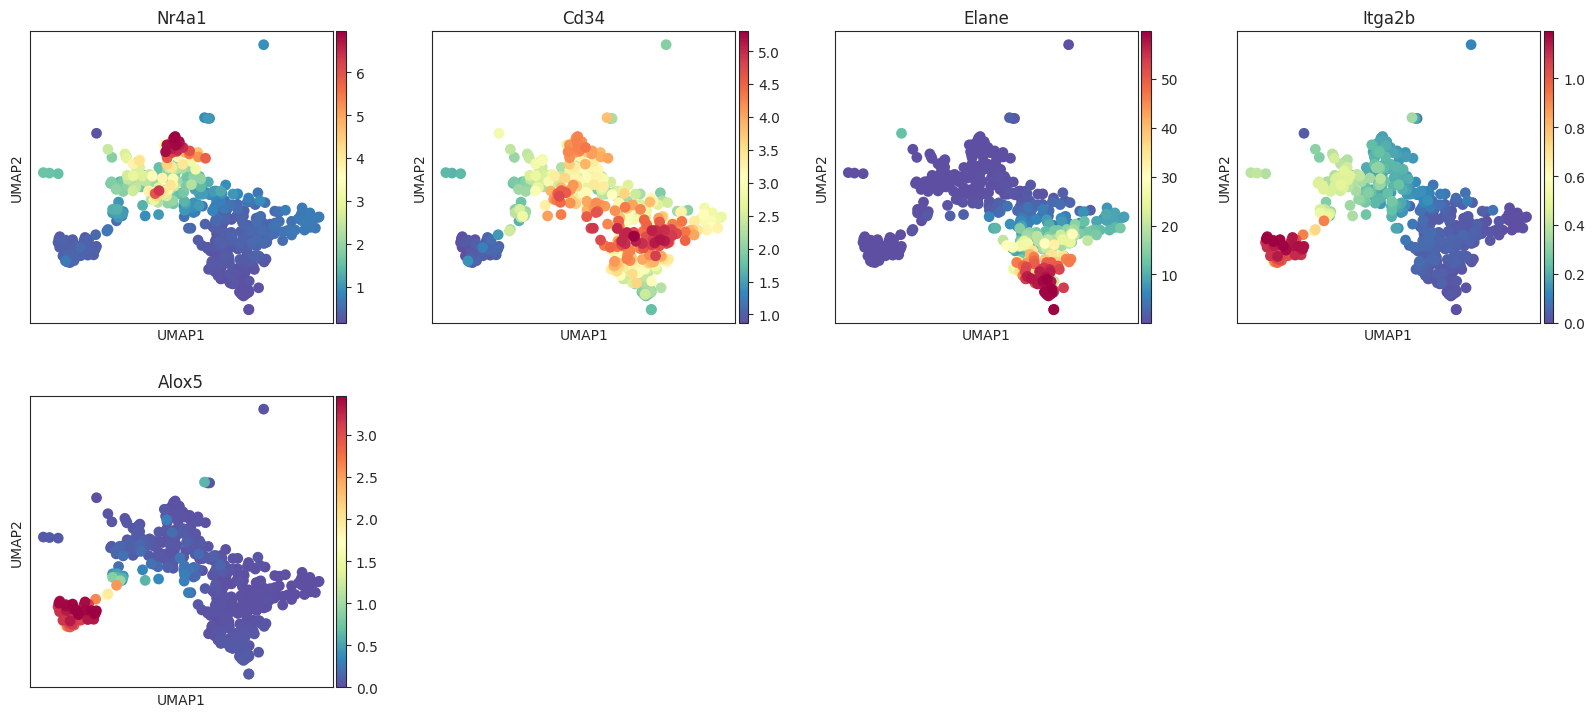

In [11]:
ad.layers['MAGIC_imputed_data'] = palantir.utils.run_magic_imputation(ad, dm_res)
#基因表达量可视化
sc.pl.embedding(ad, basis='umap', layer='MAGIC_imputed_data',
               color=["Nr4a1","Cd34","Elane","Itga2b","Alox5"])

In [38]:
# 定义可能的发育终点(optional)
terminal_states = pd.Series(['Pro_NE','Pro_Mast'], 
                           index=['TACGCTACCTGACACAGTGTTCCT_1',                                 
                            'AGAGTAGCTGTGAAGCCGTGTACT_1'])

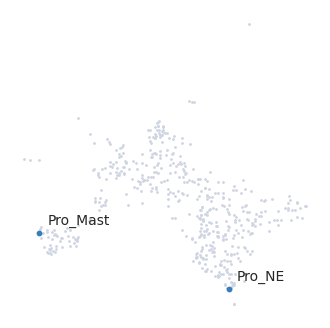

In [39]:
palantir.plot.highlight_cells_on_umap(ad, terminal_states)
plt.show()

In [40]:
## (2)轨迹推断
# 定义发育起点(required)
start_cell = ['ACGTTCAGCTATCGCATACACGCT_1']

(<Figure size 400x400 with 1 Axes>, <Axes: >)

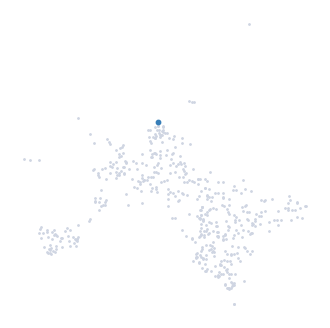

In [41]:
palantir.plot.highlight_cells_on_umap(adata, start_cell)

In [42]:
pr_res = palantir.core.run_palantir(
    ad, start_cell, num_waypoints=500, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0002875963846842448 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.004304500420888265 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [43]:
pr_res

In [44]:
pr_res.branch_probs

,Pro_Mast,Pro_NE
barcode,,
ATCACACGTTGATCCGACATAGGC_1,0.0,1.0
TGAAGACGCTATCGCAGTGTTCCT_1,0.0,1.0
CGTTGCAAGTAGAGCACCAGTGTT_1,0.0,1.0
GAAGGAAGCTTACAGCCGATGCTT_1,0.0,1.0
TTCCAAGGAGGTTCGATCGACATC_1,0.0,1.0
...,...,...
AAGCACTGTCGAACCACTCAGCTA_1,0.0,1.0
CCTGATTGTGTGCGTTAGTCAGGA_1,0.0,1.0
AGCGTGTTAGGTTCGAAACCTCCT_1,0.0,1.0


In [45]:
pr_res.pseudotime

barcode
ATCACACGTTGATCCGACATAGGC_1    0.519545
TGAAGACGCTATCGCAGTGTTCCT_1    0.199860
CGTTGCAAGTAGAGCACCAGTGTT_1    0.244819
GAAGGAAGCTTACAGCCGATGCTT_1    0.170404
TTCCAAGGAGGTTCGATCGACATC_1    0.497157
                                ...   
AAGCACTGTCGAACCACTCAGCTA_1    0.546854
CCTGATTGTGTGCGTTAGTCAGGA_1    0.635740
AGCGTGTTAGGTTCGAAACCTCCT_1    0.618070
CATGGCTAATGGTTGCGCTTAGCT_1    0.548595
GAATCCGAGACGAATGCAGTCTTC_1    0.997327
Length: 500, dtype: float64

In [46]:
pr_res.entropy

barcode
ATCACACGTTGATCCGACATAGGC_1     2.137341e-44
TGAAGACGCTATCGCAGTGTTCCT_1     4.737090e-28
CGTTGCAAGTAGAGCACCAGTGTT_1     3.694663e-26
GAAGGAAGCTTACAGCCGATGCTT_1     1.473501e-29
TTCCAAGGAGGTTCGATCGACATC_1     6.034820e-45
                                  ...      
AAGCACTGTCGAACCACTCAGCTA_1     3.380203e-49
CCTGATTGTGTGCGTTAGTCAGGA_1     1.920598e-69
AGCGTGTTAGGTTCGAAACCTCCT_1     3.987117e-64
CATGGCTAATGGTTGCGCTTAGCT_1     2.885208e-48
GAATCCGAGACGAATGCAGTCTTC_1    2.081613e-223
Length: 500, dtype: float64

In [24]:
# pseudotime, branch probability, differentiation potential
pr_res.branch_probs.to_csv("WT_Veh_branch_probs.csv")
pr_res.pseudotime.to_csv("WT_Veh_pseudotime.csv", )
pr_res.entropy.to_csv("WT_Veh_diff_potential.csv")

In [25]:
ad.obs.to_csv("WT_Veh_celltype.csv")

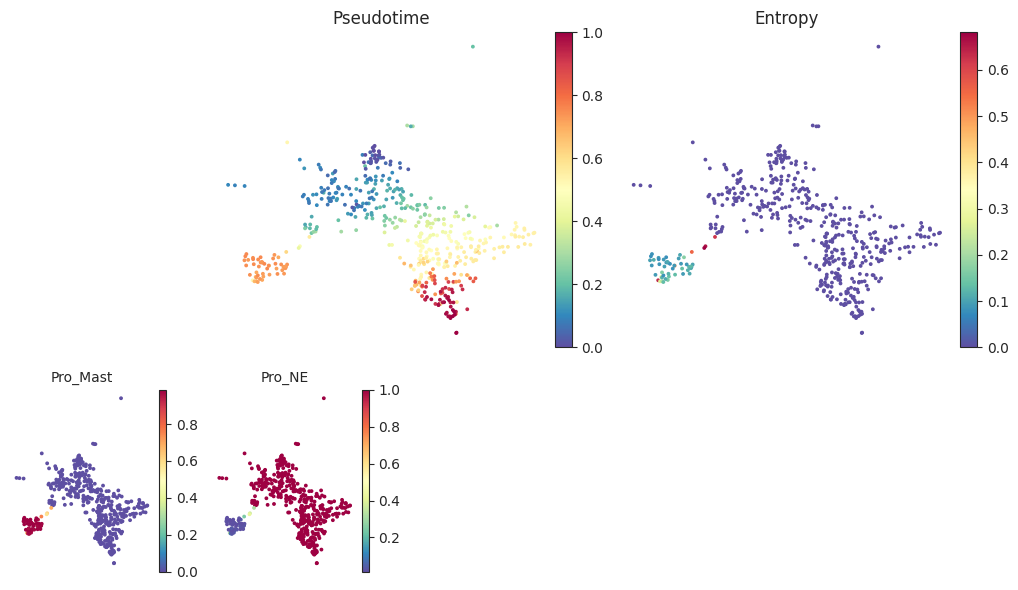

In [47]:
palantir.plot.plot_palantir_results(ad, s=3)
plt.show()

In [22]:
masks = palantir.presults.select_branch_cells(ad, eps=0)

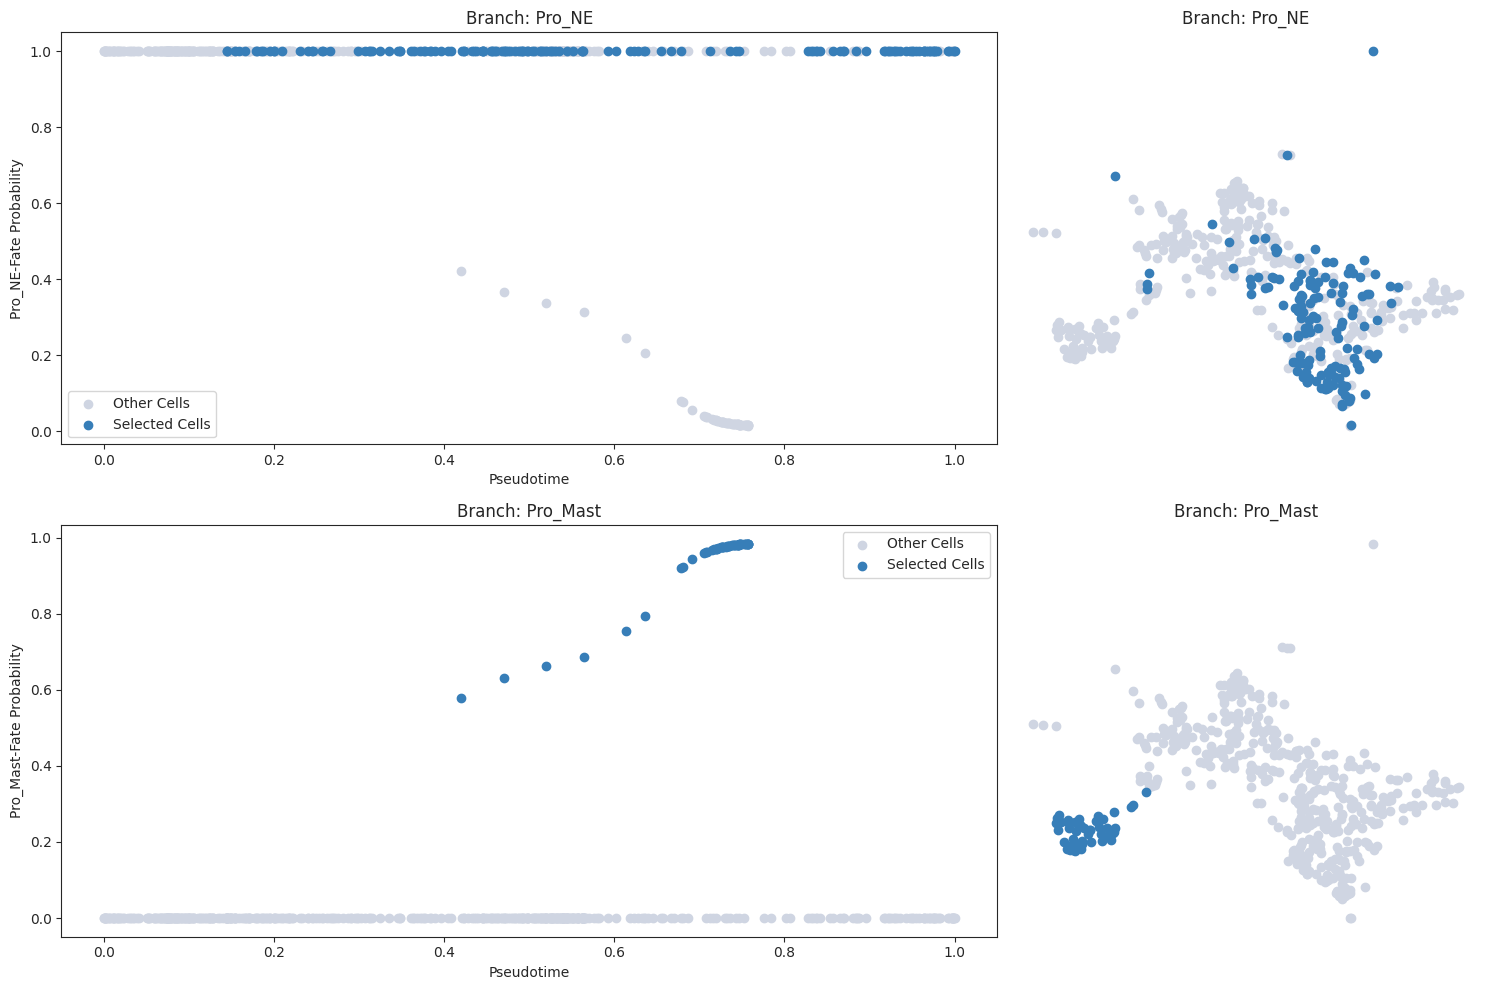

In [48]:
palantir.plot.plot_branch_selection(ad)
plt.show()